# Model with Shared Parameters Between Ys

Have $Y_{obs}$ and $Y_{unobs}$ share a unique $\mu_{G,D}$ and $\sigma_{G,D}$

# Inputs

In [1]:
import rnaseq_lib3 as r
import pymc3 as pm
import pandas as pd
import scipy.stats as st
import time
import os
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
df = pd.read_hdf('/mnt/data/expression/tcga_gtex_tpm_norm_filt.hd5')
# Subset
gtex = df[df.label == 'gtex'].sort_values('tissue')
normal = df[df.label == 'tcga-normal'].sort_values('tissue')
tumor = df[df.label == 'tcga-tumor'].sort_values('tissue')
# Read in drug genes
genes = df.columns[5:]
drug_genes = [x.split('\t')[0] for x in open('../../data/druggable-genes.tsv', 'r').readlines()]
drug_genes = [x for x in drug_genes if x in df.columns]

# Model Spec
Define inputs to model
- Sample
- Background dataset
- Training Genes

In [5]:
sample = tumor.loc['TCGA-FY-A3I4-01']
print(f"Sample comes from tissue: {sample.tissue}")
# We'll pick a subset of normal tissue for model training
test = normal[normal.tissue.isin(['Thyroid', 'Prostate', 'Kidney', 'Liver'])]
training_genes = r.outlier.select_k_best_genes(test, genes, 'tissue', 50)
classes = sorted(test.tissue.unique())
ncats = len(classes)
print(f'{ncats} background datasets and {len(training_genes)} genes')

Sample comes from tissue: Thyroid
4 background datasets and 50 genes


Define Model

In [9]:
with pm.Model() as model:
    # PRIORS
    a =  pm.Normal('a', mu=0, sd=10)
    # Beta Coefficient
    mu_b = pm.Normal('mu_b', mu=0, sd=10)
    sigma_b = pm.InverseGamma('sigma_b', 2.1, 1)
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=ncats)
    
    # Define linear model
    ys = {}
    mu = {}
    for gene in training_genes:
        for dataset in classes:
            name = f'{gene}-{dataset}'
            # Define mu and sigma that are shared between Ys (mu_{G,D} and sd_{G,D})
            y_mu = pm.Normal(f'{name}-mu', 0, 10)
            y_sigma = pm.InverseGamma(f'{name}-sd', 2.1, 1)
            y_obs = pm.Normal(f'{name}-Y-Obs', mu=y_mu, sd=y_sigma, observed=test[test.tissue == dataset][gene])
            ys[name] = pm.Normal(name, mu=y_mu, sd=y_sigma)
            
        # Define mu
        mu[gene] = a
        for i, dataset in enumerate(classes):
            mu[gene] += b[i] * ys[f'{gene}-{dataset}']
    
    # Model estimation
    eps = pm.InverseGamma('eps', 2.1, 1)
    z = {}
    for gene in training_genes:
        z[gene] = pm.Laplace(gene, mu=mu[gene], b=eps, observed=sample[gene])

# Run Model

In [12]:
out_dir = '/mnt/research_serializations/Shared-Parameters-Between-Ys'
out_path = os.path.join(out_dir, f'{sample.id}-50G-4D.pkl')
if os.path.exists(out_path):
    pkl = pickle.load(open(out_path, 'rb'))
    model, trace = pkl['model'], pkl['trace']
else:
    t0 = time.time()
    with model:
        trace = pm.sample()
    runtime = (time.time() - t0) / 60
    pkl = {}
    pkl['trace'] = trace
    pkl['model'] = model
    with open(out_path, 'wb') as f:
        pickle.dump(pkl, f)
print(f'Runtime: {runtime}')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, C3P1-Thyroid, C3P1-Thyroid-sd, C3P1-Thyroid-mu, C3P1-Prostate, C3P1-Prostate-sd, C3P1-Prostate-mu, C3P1-Liver, C3P1-Liver-sd, C3P1-Liver-mu, C3P1-Kidney, C3P1-Kidney-sd, C3P1-Kidney-mu, GYS2-Thyroid, GYS2-Thyroid-sd, GYS2-Thyroid-mu, GYS2-Prostate, GYS2-Prostate-sd, GYS2-Prostate-mu, GYS2-Liver, GYS2-Liver-sd, GYS2-Liver-mu, GYS2-Kidney, GYS2-Kidney-sd, GYS2-Kidney-mu, SLCO1B1-Thyroid, SLCO1B1-Thyroid-sd, SLCO1B1-Thyroid-mu, SLCO1B1-Prostate, SLCO1B1-Prostate-sd, SLCO1B1-Prostate-mu, SLCO1B1-Liver, SLCO1B1-Liver-sd, SLCO1B1-Liver-mu, SLCO1B1-Kidney, SLCO1B1-Kidney-sd, SLCO1B1-Kidney-mu, SLC10A1-Thyroid, SLC10A1-Thyroid-sd, SLC10A1-Thyroid-mu, SLC10A1-Prostate, SLC10A1-Prostate-sd, SLC10A1-Prostate-mu, SLC10A1-Liver, SLC10A1-Liver-sd, SLC10A1-Liver-mu, SLC10A1-Kidney, SLC10A1-Kidney-sd, SLC10A1-Kidney-mu, LECT2-Thyroid, LECT2-Thyroid-sd, LECT2-Thyroid-mu, LE

Sampling 4 chains:  89%|████████▉ | 3560/4000 [1:23:30<09:14,  1.26s/draws]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Traceplot

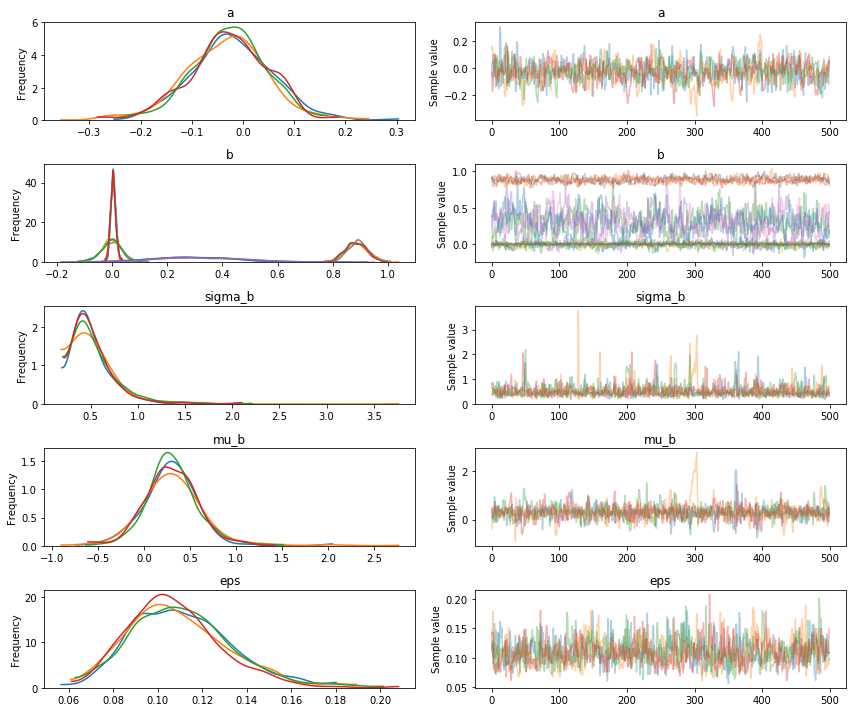

In [13]:
pm.traceplot(trace, varnames=['a', 'b', 'sigma_b', 'mu_b', 'eps']);

# Model Weights

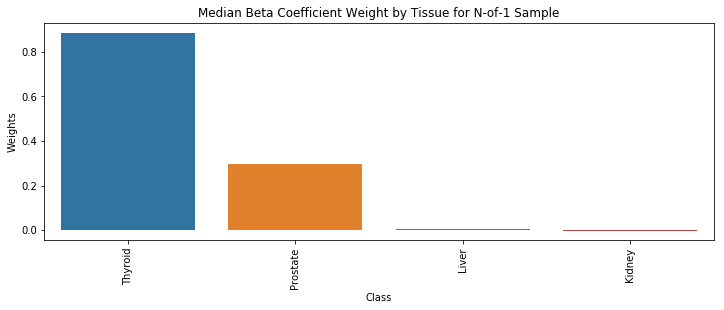

In [14]:
r.outlier.plot_weights(classes, trace)

# PPC

In [15]:
ppc = pm.sample_ppc(trace, model=model)

100%|██████████| 500/500 [02:09<00:00,  4.21it/s]


## Compare Y_obs and Y_unobs for a Gene

Text(0.5, 1.0, 'Random Gene Distribution as Compared to Y')

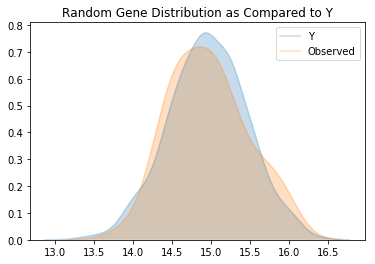

In [16]:
gene = 'HP'
sns.kdeplot(trace[f'{gene}-Liver'], label='Y', shade=True, alpha=0.25)
sns.kdeplot(normal[normal.tissue == 'Liver'][gene], label='Observed', shade=True, alpha=0.25)
plt.title('Random Gene Distribution as Compared to Y')

# Compare to Model that uses Observed Data Directly

In [60]:
m_old, t_old = r.outlier.run_model(sample, test, 'tissue', 
                                   training_genes=training_genes)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [04:15<00:00, 23.46draws/s]


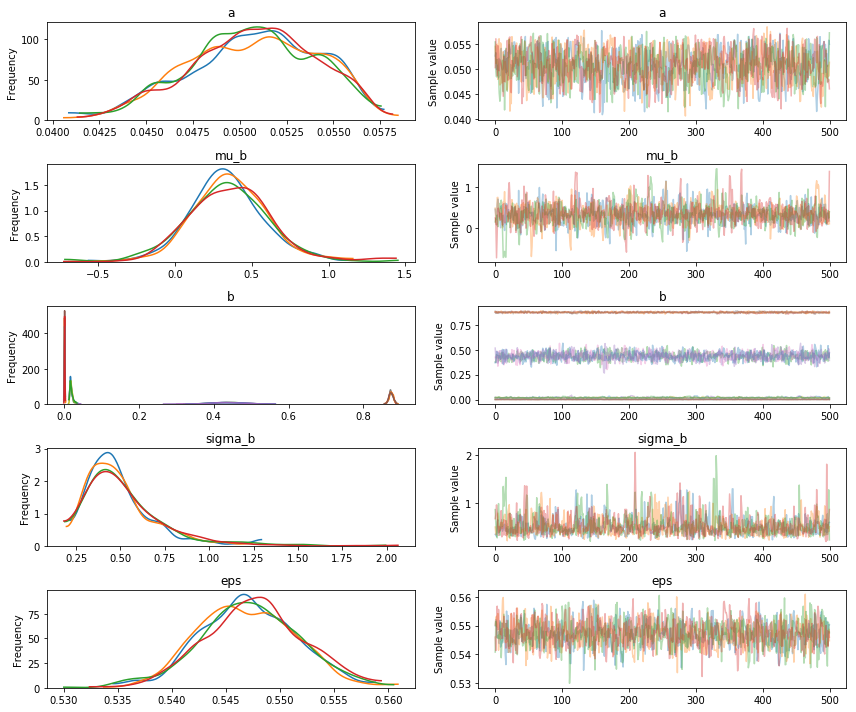

In [61]:
pm.traceplot(t_old);

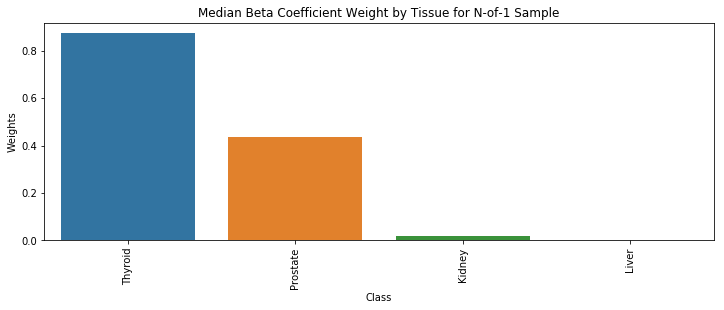

In [62]:
r.outlier.plot_weights(classes, t_old)

# Run Model on All Normals

## Model Spec

In [3]:
sample = tumor.loc['TCGA-FY-A3I4-01']
print(f"Sample comes from tissue: {sample.tissue}")
test = normal
training_genes = r.outlier.select_k_best_genes(test, genes, 'tissue', 50)
classes = sorted(test.tissue.unique())
ncats = len(classes)
print(f'{ncats} background datasets and {len(training_genes)} genes')

Sample comes from tissue: Thyroid
20 background datasets and 50 genes


In [4]:
with pm.Model() as model_normal:
    # PRIORS
    a =  pm.Normal('a', mu=0, sd=10)
    # Beta Coefficient
    mu_b = pm.Normal('mu_b', mu=0, sd=10)
    sigma_b = pm.InverseGamma('sigma_b', 2.1, 1)
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=ncats)
    
    # Define linear model
    ys = {}
    mu = {}
    for gene in training_genes:
        for dataset in classes:
            name = f'{gene}-{dataset}'
            # Define mu and sigma that are shared between Ys (mu_{G,D} and sd_{G,D})
            y_mu = pm.Normal(f'{name}-mu', 0, 10)
            y_sigma = pm.InverseGamma(f'{name}-sd', 2.1, 1)
            y_obs = pm.Normal(f'{name}-Y-Obs', mu=y_mu, sd=y_sigma, observed=test[test.tissue == dataset][gene])
            ys[name] = pm.Normal(name, mu=y_mu, sd=y_sigma)
            
        # Define mu
        mu[gene] = a
        for i, dataset in enumerate(classes):
            mu[gene] += b[i] * ys[f'{gene}-{dataset}']
    
    # Model estimation
    eps = pm.InverseGamma('eps', 2.1, 1)
    z = {}
    for gene in training_genes:
        z[gene] = pm.Laplace(gene, mu=mu[gene], b=eps, observed=sample[gene])

## Run Model

In [5]:
out_dir = '/mnt/research_serializations/Shared-Parameters-Between-Ys'
out_path = os.path.join(out_dir, f'{sample.id}-50G-normal.pkl')
if os.path.exists(out_path):
    pkl = pickle.load(open(out_path, 'rb'))
    model_normal, trace_normal = pkl['model'], pkl['trace']
else:
    t0 = time.time()
    with model_normal:
        trace_normal = pm.sample()
    runtime = (time.time() - t0) / 60
    pkl = {}
    pkl['trace'], pkl['model'] = trace_normal, model_normal
    with open(out_path, 'wb') as f:
        pickle.dump(pkl, f)
print(f'Runtime: {runtime}')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


KeyboardInterrupt: 

## Traceplot

## Model Weights